# Hedge Fund X
This notebook solve the Hedge Fund X's competition challenge: Financial Modeling challenge.
This Notebook is used to discover aspect of feature in dataset.

## Inspect data
First, check out few first line of data to see what we have.

In [11]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [12]:
df = pd.read_csv("../input/hedge_fund_x/train.csv")
df_test = pd.read_csv("../input/hedge_fund_x/test.csv")
df.head(5)

,data_id,period,c1,c2,c3,c4,c5,c6,c7,c8,...,c80,c81,c82,c83,c84,c85,c86,c87,c88,target
0,2,train1,0.655570,-0.000022,-0.000539,-0.001075,0.0,0.0,0.213390,0.0,...,-0.023358,-0.017041,0.0,0.060697,0.0,0.0,0.000000,-0.000202,-0.140220,1
1,3,train1,1.646430,-0.000292,-0.008367,0.009497,0.0,0.0,0.000000,0.0,...,-0.059429,-0.009109,0.0,0.021645,0.0,0.0,0.000000,-0.004382,0.455767,0
2,5,train1,-0.743010,0.004642,-0.000647,-0.003290,0.0,0.0,0.000000,0.0,...,0.001796,-0.000104,0.0,-0.024718,0.0,0.0,0.219566,0.072711,1.155580,0
3,7,train1,0.029770,-0.006343,-0.000635,-0.002516,0.0,0.0,0.160313,0.0,...,-0.005501,0.045308,0.0,-0.148852,0.0,0.0,0.000000,-0.101181,-0.954553,0
4,10,train1,-0.660243,0.012591,-0.002098,-0.022264,0.0,0.0,0.000000,0.0,...,0.029034,-0.005847,0.0,-0.007073,0.0,0.0,0.000000,-0.004842,0.436002,0


According to description, there is column `period` which is not present in testset. This should be the period which the data is recorded. Maybe we have to spilt dataset to period set and train only each period serparately?

Next, Summarize dataset information. I want to make sure what kind of data for each feature, number of row in dataset, data types

In [3]:
df.info()
print("----------")
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560000 entries, 0 to 559999
Data columns (total 91 columns):
data_id    560000 non-null int64
period     560000 non-null object
c1         560000 non-null float64
c2         560000 non-null float64
c3         560000 non-null float64
c4         560000 non-null float64
c5         560000 non-null float64
c6         560000 non-null float64
c7         560000 non-null float64
c8         560000 non-null float64
c9         560000 non-null float64
c10        560000 non-null float64
c11        560000 non-null float64
c12        560000 non-null float64
c13        560000 non-null float64
c14        560000 non-null float64
c15        560000 non-null float64
c16        560000 non-null float64
c17        560000 non-null float64
c18        560000 non-null float64
c19        560000 non-null float64
c20        560000 non-null float64
c21        560000 non-null float64
c22        560000 non-null float64
c23        560000 non-null float64
c24        560000

### Check period

In [4]:
print df.groupby(['period'])['data_id'].count()

period
train1     40000
train10    40000
train11    40000
train12    40000
train13    40000
train14    40000
train2     40000
train3     40000
train4     40000
train5     40000
train6     40000
train7     40000
train8     40000
train9     40000
Name: data_id, dtype: int64


There are 14 periods. Let's examine the first 1

In [5]:
# We drop column period to make it same as test dataset
train1_df = df[df.period == 'train1'].drop(['period'], axis=1)

In [6]:
train1_size = train1_df.shape[0]
zero_count = (train1_df==0.0).sum(axis=0).sort_values(ascending=False)
has_zero_ratio = zero_count[zero_count > 0].div(train1_size)
print has_zero_ratio
print "Has zero value feature count: {}".format(has_zero_ratio.shape[0])
missing_percent = 0.995
high_missing_count = has_zero_ratio[has_zero_ratio >= missing_percent].shape[0]
print "Missing over {}%: {}".format(missing_percent*100, high_missing_count)

c8        0.998
c37       0.998
c34       0.998
c45       0.998
c23       0.996
c18       0.992
c6        0.990
c62       0.988
c28       0.988
c85       0.986
c46       0.986
c60       0.984
c55       0.982
c65       0.982
c5        0.982
c32       0.982
c41       0.980
c54       0.978
c86       0.978
c70       0.976
c63       0.962
c82       0.960
c7        0.960
c19       0.946
c58       0.946
c52       0.946
c17       0.944
c10       0.944
c13       0.934
c84       0.926
c75       0.900
c42       0.890
target    0.500
dtype: float64
Has zero value feature count: 33
Missing over 99.5%: 5


There are 32 feature with "missing data", or over **89%** of data is zero. Normally, missing data should be represented as Nan or null, however, we have a lot of zeros here. I think we can treat them as missing data.

### Measure correlation
First, checkout the correlation between features with target

In [7]:
corr_df = train1_df.corr(method='spearman')['target'].sort_values(ascending=False)
print corr_df

target    1.000000
c75       0.047588
c67       0.032183
c46       0.032104
c20       0.029759
c27       0.029245
c31       0.029209
c74       0.028679
c86       0.026996
c39       0.025113
c43       0.023896
c63       0.020870
c76       0.020389
c47       0.018161
c73       0.017862
c78       0.016764
c8        0.015678
c82       0.014182
c16       0.011847
c65       0.010751
c41       0.010585
c36       0.009839
c56       0.009456
c87       0.008602
c29       0.008325
c17       0.008306
c32       0.007953
c44       0.007899
c3        0.007369
c6        0.006030
            ...   
c81      -0.013045
c37      -0.013456
c40      -0.013489
c25      -0.013627
c69      -0.014003
c34      -0.014558
c35      -0.015025
c62      -0.016642
c42      -0.016748
c52      -0.016811
c77      -0.018073
c5       -0.018403
c55      -0.019387
c21      -0.019666
c83      -0.019795
c38      -0.021756
c54      -0.022748
c15      -0.023297
c66      -0.024126
c10      -0.025044
c28      -0.033490
c1       -0.

There is not strong correlation (max is 0.06). Let's check heatmap of highest features

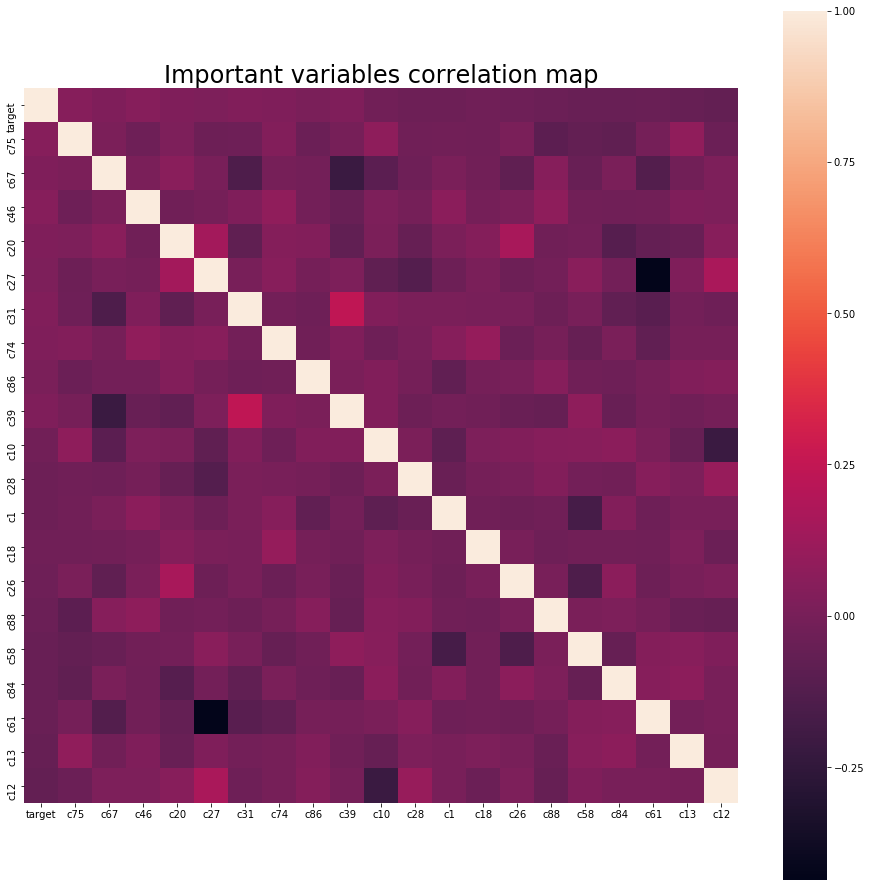

In [8]:
high_corr_df = corr_df[abs(corr_df) > 0.025]
cm = np.corrcoef(train1_df[high_corr_df.index].values.T)
f, ax = plt.subplots(figsize=(16, 16))
hm = sns.heatmap(cm,
                 square=True,
                 yticklabels=train1_df[high_corr_df.index].axes[1],
                 xticklabels=train1_df[high_corr_df.index].axes[1])
plt.title("Important variables correlation map", fontsize=24)
plt.show()

The heat map looks "cold". The most important variables are not quite related to each other.

## Data distribution